In [1]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.ndimage import gaussian_filter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model


### Density Map Generator

In [2]:
def generate_density_map(img_path, mat_path, output_shape):
    img = cv2.imread(img_path)
    h, w = img.shape[:2]
    points = loadmat(mat_path)["annPoints"]

    density_map = np.zeros((h, w), dtype=np.float32)
    for point in points:
        x, y = int(point[0]), int(point[1])
        if 0 <= x < w and 0 <= y < h:
            density_map[y, x] = 1

    density_map = gaussian_filter(density_map, sigma=15)
    density_map = cv2.resize(density_map, output_shape)
    return density_map


### Prepare Image and Annotation Paths

In [3]:
def get_img_and_mat_paths(root):
    img_paths, mat_paths = [], []
    for fname in os.listdir(root):
        if fname.endswith(".jpg"):
            img_path = os.path.join(root, fname)
            mat_path = os.path.join(root, fname.replace(".jpg", "_ann.mat"))
            if os.path.exists(mat_path):
                img_paths.append(img_path)
                mat_paths.append(mat_path)
    return sorted(img_paths), sorted(mat_paths)

train_img_paths, train_mat_paths = get_img_and_mat_paths("UCF-QNRF_ECCV18/Train")
test_img_paths, test_mat_paths = get_img_and_mat_paths("UCF-QNRF_ECCV18/Test")


### Dataset Loader

In [4]:
img_size = (320, 320)
batch_size = 4

def get_dataset(img_paths, mat_paths, batch_size, img_size):
    def load_img_and_density(img_path, mat_path):
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, img_size)
        img = tf.image.convert_image_dtype(img, tf.float32)

        def _load_density_map(py_img_path, py_mat_path):
            img_path_str = py_img_path.numpy().decode()
            mat_path_str = py_mat_path.numpy().decode()
            density = generate_density_map(img_path_str, mat_path_str, img_size)
            density = np.expand_dims(density, axis=-1)
            return density.astype(np.float32)

        density = tf.py_function(_load_density_map, [img_path, mat_path], tf.float32)
        density.set_shape([img_size[0], img_size[1], 1])
        return img, density

    dataset = tf.data.Dataset.from_tensor_slices((img_paths, mat_paths))
    dataset = dataset.map(load_img_and_density, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)


### MCNN Model

In [10]:
def build_mcnn(input_shape=(320, 320, 3)):
    inputs = keras.Input(shape=input_shape)

    def mcnn_branch(x, filters, kernel_size):
        x = layers.Conv2D(filters, kernel_size, padding='same', activation='relu')(x)
        x = layers.MaxPooling2D(2)(x)
        x = layers.Conv2D(filters, kernel_size, padding='same', activation='relu')(x)
        x = layers.MaxPooling2D(2)(x)
        return x

    # Three columns with different receptive fields
    col1 = mcnn_branch(inputs, 16, 9)
    col2 = mcnn_branch(inputs, 20, 7)
    col3 = mcnn_branch(inputs, 24, 5)

    # Merge columns
    merged = layers.concatenate([col1, col2, col3])
    merged = layers.Conv2D(1, 1, padding='same', activation='relu')(merged)

    # Upsample back to original input size
    output = layers.UpSampling2D(size=4, interpolation='bilinear')(merged)
    return Model(inputs, output)

model = build_mcnn()
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 320, 320,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 320, 320,  │      3,904 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 320, 320,  │      2,960 │ input_layer_1[0]… │
│                     │ 20)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 320, 320,  │      1,824 │ input_layer_1[0]… │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 160, 160,  │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 160, 160,  │          0 │ conv2d_9[0][0]    │
│ (MaxPooling2D)      │ 20)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 160, 160,  │          0 │ conv2d_11[0][0]   │
│ (MaxPooling2D)      │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 160, 160,  │     20,752 │ max_pooling2d_6[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 160, 160,  │     19,620 │ max_pooling2d_8[… │
│                     │ 20)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 160, 160,  │     14,424 │ max_pooling2d_10… │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 80, 80,    │          0 │ conv2d_8[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 80, 80,    │          0 │ conv2d_10[0][0]   │
│ (MaxPooling2D)      │ 20)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 80, 80,    │          0 │ conv2d_12[0][0]   │
│ (MaxPooling2D)      │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 80, 80,    │          0 │ max_pooling2d_7[… │
│ (Concatenate)       │ 60)               │            │ max_pooling2d_9[… │
│                     │                   │            │ max_pooling2d_11… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 80, 80, 1) │         61 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 320, 320,  │          0 │ conv2d_13[0][0]   │
│ (UpSampling2D)      │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 63,545 (248.22 KB)

 Trainable params: 63,545 (248.22 KB)

 Non-trainable params: 0 (0.00 B)

### Compile and Train Model

In [11]:
train_dataset = get_dataset(train_img_paths, train_mat_paths, batch_size, img_size)
val_dataset = get_dataset(test_img_paths, test_mat_paths, batch_size, img_size)

model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss='mse',
    metrics=['mae']
)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    verbose=2
)


Epoch 1/30


Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9


301/301 - 167s - 555ms/step - loss: 5.4248e-05 - mae: 4.2816e-04 - val_loss: 1.4825e-06 - val_mae: 3.7015e-04
Epoch 2/30


Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9


301/301 - 161s - 534ms/step - loss: 2.1018e-06 - mae: 4.2003e-04 - val_loss: 1.4825e-06 - val_mae: 3.7015e-04
Epoch 3/30


Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9


301/301 - 479s - 2s/step - loss: 2.1005e-06 - mae: 4.2001e-04 - val_loss: 1.4825e-06 - val_mae: 3.7015e-04
Epoch 4/30


Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9


301/301 - 1067s - 4s/step - loss: 2.1001e-06 - mae: 4.2000e-04 - val_loss: 1.4825e-06 - val_mae: 3.7015e-04
Epoch 5/30


Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9


301/301 - 157s - 521ms/step - loss: 2.1000e-06 - mae: 4.1999e-04 - val_loss: 1.4825e-06 - val_mae: 3.7015e-04
Epoch 6/30


Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9


301/301 - 158s - 526ms/step - loss: 2.1000e-06 - mae: 4.1999e-04 - val_loss: 1.4825e-06 - val_mae: 3.7015e-04
Epoch 7/30


Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9


301/301 - 156s - 518ms/step - loss: 2.1000e-06 - mae: 4.1999e-04 - val_loss: 1.4825e-06 - val_mae: 3.7015e-04
Epoch 8/30


Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9


301/301 - 155s - 516ms/step - loss: 2.1000e-06 - mae: 4.1999e-04 - val_loss: 1.4825e-06 - val_mae: 3.7015e-04
Epoch 9/30


Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9


301/301 - 156s - 517ms/step - loss: 2.1000e-06 - mae: 4.1999e-04 - val_loss: 1.4825e-06 - val_mae: 3.7015e-04
Epoch 10/30


Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9


301/301 - 156s - 519ms/step - loss: 2.1000e-06 - mae: 4.1999e-04 - val_loss: 1.4825e-06 - val_mae: 3.7015e-04
Epoch 11/30


Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9


301/301 - 159s - 530ms/step - loss: 2.1000e-06 - mae: 4.1999e-04 - val_loss: 1.4825e-06 - val_mae: 3.7015e-04
Epoch 12/30


Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9


301/301 - 162s - 539ms/step - loss: 2.1000e-06 - mae: 4.1999e-04 - val_loss: 1.4825e-06 - val_mae: 3.7015e-04
Epoch 13/30


Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9


301/301 - 171s - 567ms/step - loss: 2.1000e-06 - mae: 4.1999e-04 - val_loss: 1.4825e-06 - val_mae: 3.7015e-04
Epoch 14/30


Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9


301/301 - 160s - 531ms/step - loss: 2.1000e-06 - mae: 4.1999e-04 - val_loss: 1.4825e-06 - val_mae: 3.7015e-04
Epoch 15/30


Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9


301/301 - 161s - 536ms/step - loss: 2.1000e-06 - mae: 4.1999e-04 - val_loss: 1.4825e-06 - val_mae: 3.7015e-04
Epoch 16/30


Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9


301/301 - 162s - 539ms/step - loss: 2.1000e-06 - mae: 4.1999e-04 - val_loss: 1.4825e-06 - val_mae: 3.7015e-04
Epoch 17/30


Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9


301/301 - 162s - 539ms/step - loss: 2.1000e-06 - mae: 4.1999e-04 - val_loss: 1.4825e-06 - val_mae: 3.7015e-04
Epoch 18/30


Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9


301/301 - 164s - 545ms/step - loss: 2.1000e-06 - mae: 4.1999e-04 - val_loss: 1.4825e-06 - val_mae: 3.7015e-04
Epoch 19/30


Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9


301/301 - 163s - 541ms/step - loss: 2.1000e-06 - mae: 4.1999e-04 - val_loss: 1.4825e-06 - val_mae: 3.7015e-04
Epoch 20/30


Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9


301/301 - 165s - 547ms/step - loss: 2.1000e-06 - mae: 4.1999e-04 - val_loss: 1.4825e-06 - val_mae: 3.7015e-04
Epoch 21/30


Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9


301/301 - 165s - 548ms/step - loss: 2.1000e-06 - mae: 4.1999e-04 - val_loss: 1.4825e-06 - val_mae: 3.7015e-04
Epoch 22/30


Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9


301/301 - 165s - 548ms/step - loss: 2.1000e-06 - mae: 4.1999e-04 - val_loss: 1.4825e-06 - val_mae: 3.7015e-04
Epoch 23/30


Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9


301/301 - 165s - 547ms/step - loss: 2.1000e-06 - mae: 4.1999e-04 - val_loss: 1.4825e-06 - val_mae: 3.7015e-04
Epoch 24/30


Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9


301/301 - 163s - 543ms/step - loss: 2.1000e-06 - mae: 4.1999e-04 - val_loss: 1.4825e-06 - val_mae: 3.7015e-04
Epoch 25/30


Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9


301/301 - 161s - 535ms/step - loss: 2.1000e-06 - mae: 4.1999e-04 - val_loss: 1.4825e-06 - val_mae: 3.7015e-04
Epoch 26/30


Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9


301/301 - 162s - 538ms/step - loss: 2.1000e-06 - mae: 4.1999e-04 - val_loss: 1.4825e-06 - val_mae: 3.7015e-04
Epoch 27/30


Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9


301/301 - 161s - 533ms/step - loss: 2.1000e-06 - mae: 4.1999e-04 - val_loss: 1.4825e-06 - val_mae: 3.7015e-04
Epoch 28/30


Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9


301/301 - 160s - 532ms/step - loss: 2.1000e-06 - mae: 4.1999e-04 - val_loss: 1.4825e-06 - val_mae: 3.7015e-04
Epoch 29/30


Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9


301/301 - 161s - 535ms/step - loss: 2.1000e-06 - mae: 4.1999e-04 - val_loss: 1.4825e-06 - val_mae: 3.7015e-04
Epoch 30/30


Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 61 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9
Corrupt JPEG data: 21 extraneous bytes before marker 0xd9


301/301 - 158s - 526ms/step - loss: 2.1000e-06 - mae: 4.1999e-04 - val_loss: 1.4825e-06 - val_mae: 3.7015e-04


### Plot Loss and MAE

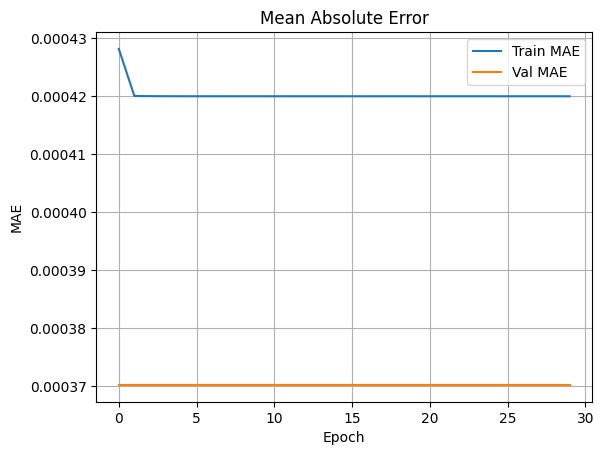

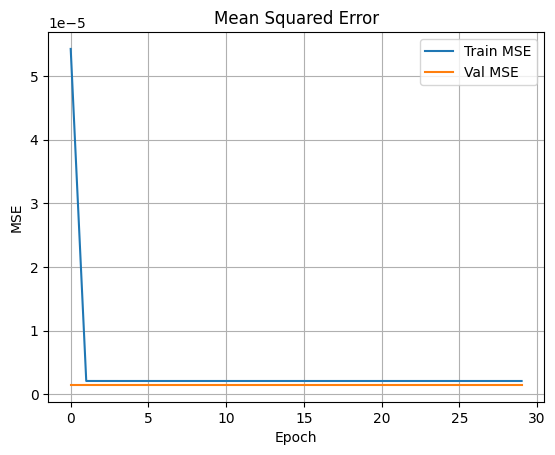

In [12]:
plt.plot(history.history["mae"], label="Train MAE")
plt.plot(history.history["val_mae"], label="Val MAE")
plt.title("Mean Absolute Error")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.grid(True)
plt.legend()
plt.show()

plt.plot(history.history["loss"], label="Train MSE")
plt.plot(history.history["val_loss"], label="Val MSE")
plt.title("Mean Squared Error")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.grid(True)
plt.legend()
plt.show()


### Visualize Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


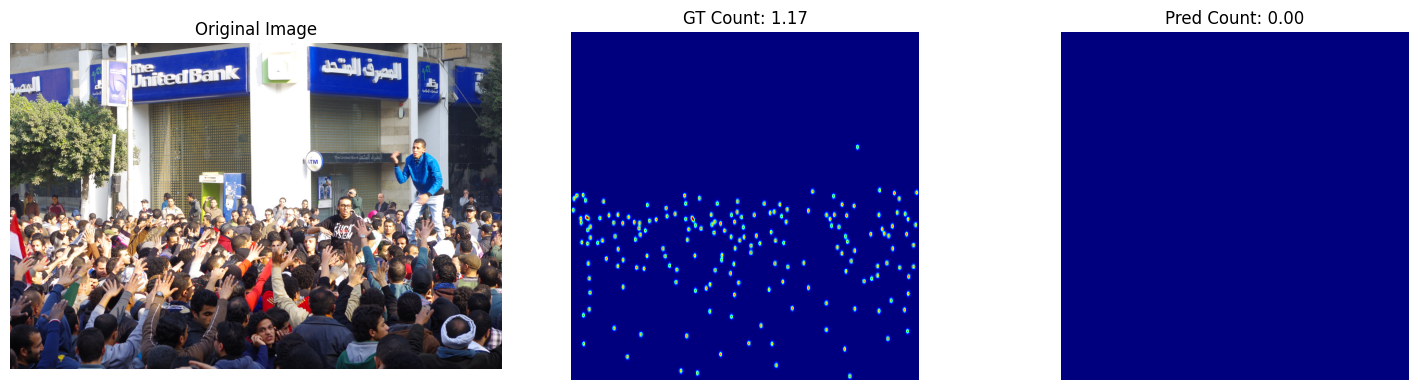

In [15]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os

def visualize_prediction(index):
    # Load original image from file (before resizing or normalization)
    orig_img_path = test_img_paths[index]
    orig_img = cv2.imread(orig_img_path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

    # Get preprocessed image and density map from dataset
    test_imgs, test_density = next(iter(val_dataset))  # small batch
    true_density = test_density[index].numpy()
    pred_density = model.predict(tf.expand_dims(test_imgs[index], axis=0))[0]

    plt.figure(figsize=(15, 4))

    # Show original image (unmodified)
    plt.subplot(1, 3, 1)
    plt.imshow(orig_img)
    plt.title("Original Image")
    plt.axis("off")

    # Show ground-truth density map
    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(true_density), cmap='jet')
    plt.title(f"GT Count: {np.sum(true_density):.2f}")
    plt.axis("off")

    # Show predicted density map
    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(pred_density), cmap='jet')
    plt.title(f"Pred Count: {np.sum(pred_density):.2f}")
    plt.axis("off")

    plt.tight_layout()
    plt.show()
visualize_prediction(3)    
